# Feature Importance Analysis

## Load processed dataset


In [ ]:
# Upload files to colab environment
from google.colab import files
uploaded = files.upload()

Saving processed_final_dataset-nn.csv to processed_final_dataset-nn.csv


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Check if GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load processed dataset
data = pd.read_csv('processed_final_dataset.csv')

# Separate features and target variable
X = data.drop(columns=['has_readmission'])
y = data['has_readmission']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Using device: cpu


## Standardisation

In [ ]:
# Step 1: Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

# Helper function for evaluating model performance
def evaluate_model(y_true, y_pred, model_name):
    y_pred_labels = (y_pred > 0.5).float()
    accuracy = accuracy_score(y_true, y_pred_labels.cpu().numpy())
    precision = precision_score(y_true, y_pred_labels.cpu().numpy())
    recall = recall_score(y_true, y_pred_labels.cpu().numpy())
    f1 = f1_score(y_true, y_pred_labels.cpu().numpy())
    auc = roc_auc_score(y_true, y_pred.cpu().numpy())

    print(f"\n{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred_labels.cpu().numpy()))

    # Initialize a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Plot 1: Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred_labels.cpu().numpy())
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
    axes[0, 0].set_title(f'{model_name} - Confusion Matrix')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')

    # Plot 2: ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred.cpu().numpy())
    axes[0, 1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
    axes[0, 1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axes[0, 1].set_title(f'{model_name} - ROC Curve')
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].legend(loc='lower right')

    # Plot 3: Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred.cpu().numpy())
    axes[1, 0].plot(recall_vals, precision_vals, marker='.')
    axes[1, 0].set_title(f'{model_name} - Precision-Recall Curve')
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')

    # Hide the fourth subplot (bottom-right)
    axes[1, 1].axis('off')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


##Modelling

### Please run functional models in other jupyter notebooks


### Train & Evaluation

In [ ]:
# Training function
def train_model(model, X_train, y_train, epochs=20, batch_size=32, learning_rate=0.001):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Train and evaluate each model
input_size = X_train.shape[1]

In [ ]:
# Training function with loss tracking
def train_model(model, X_train, y_train, epochs=20, batch_size=32, learning_rate=0.001):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    loss_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        if (epoch+1) % 5 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    # Plot the loss curve
    plt.plot(range(1, epochs + 1), loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

# Define models (Sequential NN, MLP, 1D CNN)
input_size = X_train.shape[1]

# Feature Importance Analysis

## SHAP
### See in modelling part

## Clustering

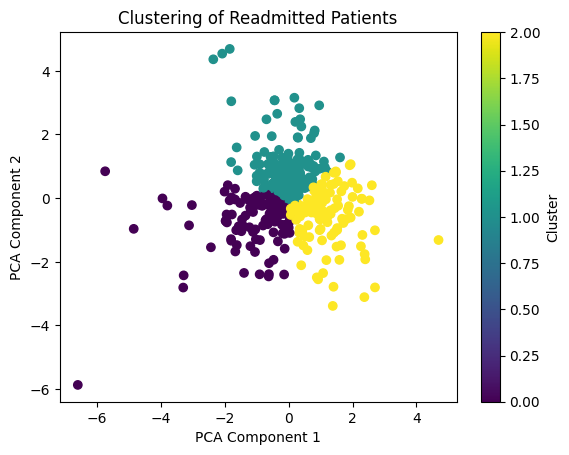

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Convert X_test_tensor to NumPy array if needed
X_test_np = X_test_tensor.cpu().numpy() if X_test_tensor.is_cuda else X_test_tensor.numpy()

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_np)

# Perform K-means clustering on the reduced test set
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_test_pca)

# Plot the clusters
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=clusters, cmap='viridis')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clustering of Readmitted Patients")
plt.colorbar(label="Cluster")
plt.show()


In [ ]:
import pandas as pd
from scipy.stats import ttest_ind

# Convert X_test_tensor to a DataFrame
X_test_df = pd.DataFrame(X_test_np, columns=[f'Feature{i+1}' for i in range(X_test_np.shape[1])])
X_test_df['Cluster'] = clusters

# Describe clusters
cluster_summary = X_test_df.groupby('Cluster').mean()
print("Cluster Summary (Mean Values):\n", cluster_summary)

# Compare clusters for significant differences in each feature
for feature in X_test_df.columns[:-1]:  # Exclude 'Cluster' column
    for i in range(len(cluster_summary) - 1):
        for j in range(i + 1, len(cluster_summary)):
            cluster_1 = X_test_df[X_test_df['Cluster'] == i][feature]
            cluster_2 = X_test_df[X_test_df['Cluster'] == j][feature]
            t_stat, p_val = ttest_ind(cluster_1, cluster_2)
            print(f"T-test for {feature} between Cluster {i} and {j}: p-value = {p_val:.5f}")

Cluster Summary (Mean Values):
          Feature1  Feature2  Feature3  Feature4  Feature5  Feature6  Feature7  \
Cluster                                                                         
0        0.096487 -0.267556  0.461560  0.158694 -0.682748 -0.039654 -0.393331   
1       -0.238039 -0.046052 -0.008494 -0.012429  0.092282  0.197111  0.129499   
2        0.311442  0.065898 -0.195189  0.127157  0.617625 -0.271603  0.330226   

         Feature8  Feature9  Feature10  Feature11  Feature12  Feature13  \
Cluster                                                                   
0       -0.239846 -0.120090   0.275601  -0.270046   0.697755   0.343501   
1        0.434382  0.004086  -0.158473   0.345261  -0.041705  -0.441345   
2       -0.394877  0.181858  -0.143146  -0.067399  -0.091390   0.559487   

         Feature14  Feature15  Feature16  Feature17  
Cluster                                              
0         0.028935   0.151652   0.055036   0.352253  
1        -0.318371   0.1

## Random Forest Feature Importance

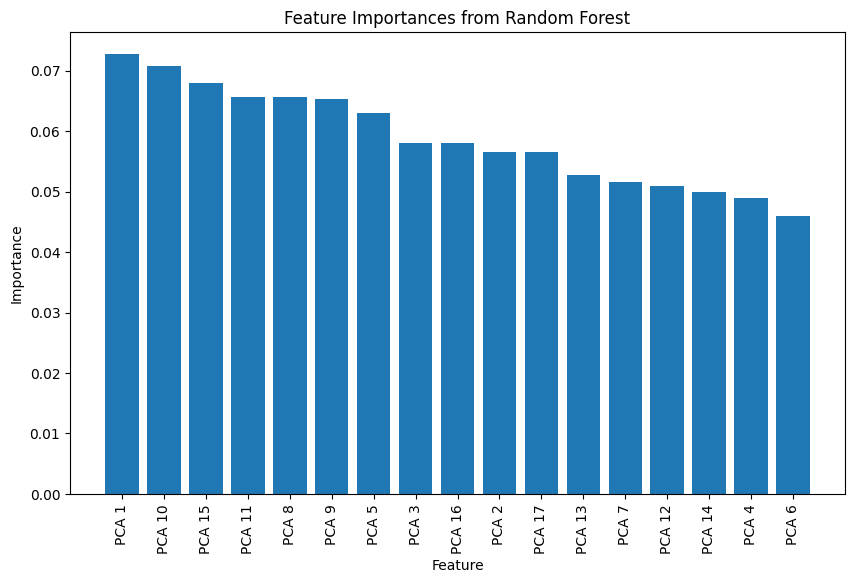

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Convert X_test_tensor to numpy if necessary
X_test_np = X_test_tensor.cpu().numpy() if isinstance(X_test_tensor, torch.Tensor) and X_test_tensor.is_cuda else X_test_tensor.numpy()

# Assuming y_test is already a pandas Series, no conversion needed
y_test_np = y_test.values  # Convert to numpy array if needed

# Train a Random Forest on the test set (for feature importance analysis)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_test_np, y_test_np)

# Get feature importance
feature_importances = rf_model.feature_importances_

# Plot feature importance
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances from Random Forest")
plt.bar(range(X_test_np.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_test_np.shape[1]), [f'PCA {i+1}' for i in indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()


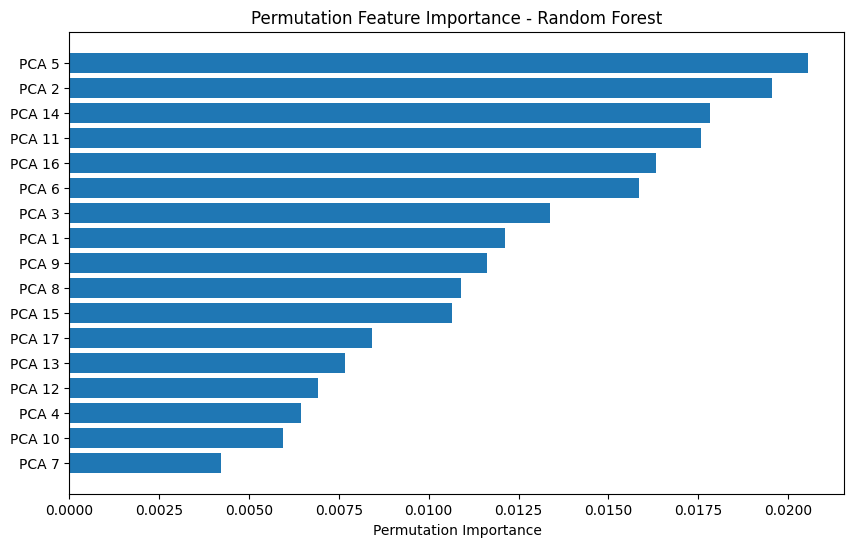

In [ ]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(rf_model, X_test_np, y_test_np, n_repeats=10, random_state=42)

# Plot permutation importance
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [f'PCA {i+1}' for i in sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Feature Importance - Random Forest")
plt.show()


## Linear Regression Coeffiecients for Feature Importance

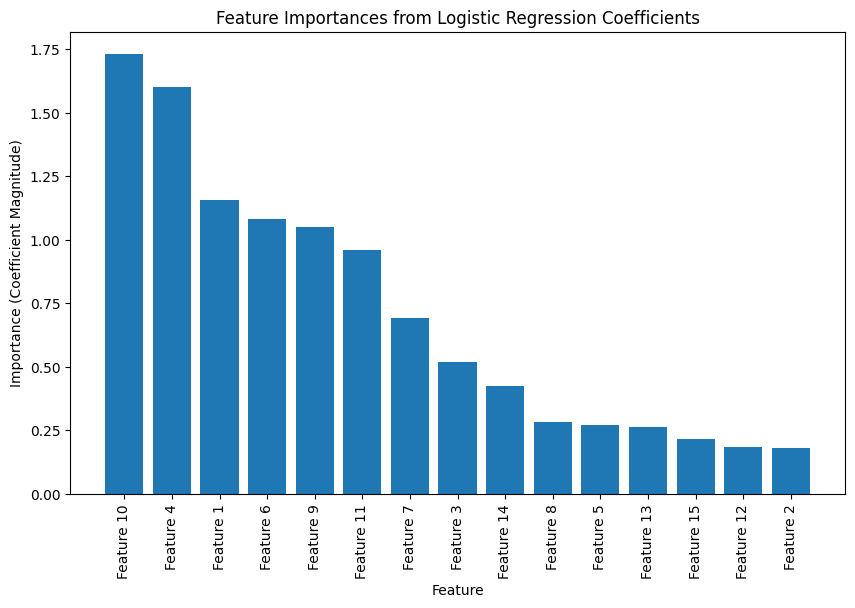

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale features (important for Logistic Regression to interpret coefficient importance correctly)
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test_np)

# Fit a Logistic Regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_test_scaled, y_test_np)

# Get absolute values of coefficients for feature importance
feature_importances = np.abs(lr_model.coef_[0])

# Plot feature importance
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances from Logistic Regression Coefficients")
plt.bar(range(X_test_scaled.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_test_scaled.shape[1]), [f'Feature {i+1}' for i in indices], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance (Coefficient Magnitude)")
plt.show()


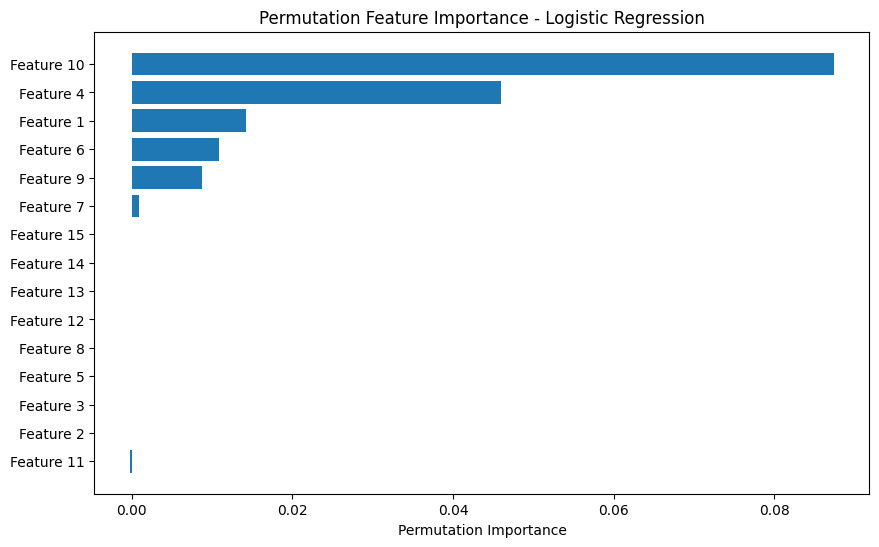

In [ ]:
# Calculate permutation importance for Logistic Regression
perm_importance_lr = permutation_importance(lr_model, X_test_scaled, y_test_np, n_repeats=10, random_state=42)

# Plot permutation importance
sorted_idx_lr = perm_importance_lr.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx_lr)), perm_importance_lr.importances_mean[sorted_idx_lr], align="center")
plt.yticks(range(len(sorted_idx_lr)), [f'Feature {i+1}' for i in sorted_idx_lr])
plt.xlabel("Permutation Importance")
plt.title("Permutation Feature Importance - Logistic Regression")
plt.show()
